In [2]:
import pandas as pd
import numpy as np
import gizeh
import moviepy.editor as mpe
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

import utils

Instructions for updating:
Use the retry module or similar alternatives.


In [3]:
video_name = "JustSomeMotion_CaravanPalace_Brotherswing"
path = "./data/video/{0}.mp4".format(video_name)
pose_dir = './data/poses/{0}'.format(video_name)
print(path)

step_size = 10

./data/video/JustSomeMotion_CaravanPalace_Brotherswing.mp4


In [3]:
# utils.preprocess(video_name, 20)

video length: 220.89s fps: 29.97002997002997 frame count: 599
INFO:tensorflow:Restoring parameters from pose-tensorflow/models/mpii/mpii-single-resnet-101


INFO:tensorflow:Restoring parameters from pose-tensorflow/models/mpii/mpii-single-resnet-101


pose model loaded
processed frame: 0/599 elapsed time: 10.221794128417969
processed frame: 100/599 elapsed time: 438.1103141307831
processed frame: 200/599 elapsed time: 869.1626210212708
processed frame: 300/599 elapsed time: 1300.46737408638
processed frame: 400/599 elapsed time: 1731.6231322288513
processed frame: 500/599 elapsed time: 2164.064560174942
saving poses at ./data/poses/JustSomeMotion_CaravanPalace_Brotherswing_poses.csv
saving audio at ./data/audio/JustSomeMotion_CaravanPalace_Brotherswing.mp3
[MoviePy] Writing audio in ./data/audio/JustSomeMotion_CaravanPalace_Brotherswing.mp3


100%|██████████| 4871/4871 [00:13<00:00, 361.99it/s]

[MoviePy] Done.


total time: 2603.8190898895264


In [18]:
df = pd.read_csv('./data/poses/JustSomeMotion_CaravanPalace_Brotherswing_poses.csv')
times = df['time'].as_matrix()
df = df.drop('time', axis=1)

df_matrix = df.as_matrix()

df.columns.values

array(['ankle_0_x', 'ankle_0_y', 'ankle_1_x', 'ankle_1_y', 'knee_0_x',
       'knee_0_y', 'knee_1_x', 'knee_1_y', 'hip_0_x', 'hip_0_y',
       'hip_1_x', 'hip_1_y', 'wrist_0_x', 'wrist_0_y', 'wrist_1_x',
       'wrist_1_y', 'elbow_0_x', 'elbow_0_y', 'elbow_1_x', 'elbow_1_y',
       'shoulder_0_x', 'shoulder_0_y', 'shoulder_1_x', 'shoulder_1_y',
       'chin_0_x', 'chin_0_y', 'forehead_0_x', 'forehead_0_y'],
      dtype=object)

In [19]:
shape = df_matrix.shape
m = np.zeros((shape[0], int(shape[1]/2), 2))
for i in range(0, m.shape[0]):
   for j in range(0, m.shape[1]):
       m[i][j] = (df_matrix[i][2*j], df_matrix[i][2*j+1])

In [20]:
original = mpe.VideoFileClip('./data/video/JustSomeMotion_CaravanPalace_Brotherswing.mp4')
fps = int(original.fps)
duration = original.duration

In [21]:
def make_frame(t):
    surface = gizeh.Surface(original.size[0],original.size[1])
    frame = int(t * fps)
    radius = 10
    color = (1,0,0)
    for i in range(0, m.shape[1]):
        circle = gizeh.circle(radius, xy = m[t][i], fill=color)
        circle.draw(surface)
    return surface.get_npimage()

In [34]:
index = int(len(times) / 2) + 50
t = times[index]
print(t)

11.644966666666667


In [35]:
# prediction = utils.predict_frame(original, t)

In [36]:
#cleaned = np.delete(prediction, 2, axis=1)
#print(cleaned)

#print(m[index])

#print(df_matrix[index])

In [31]:
def find_index(t, times):
    for i in range(len(times)):
        if times[i] >= t:
            return i

In [135]:
def draw_bone(ax, start, end, width = 15, color = (0.7,0,0)):
    ax.arrow(start[0], start[1], end[0] - start[0], end[1] - start[1], 
             width=width, head_width=0, head_length=0, color=color)


In [159]:
def make_frame(t):
    from matplotlib.figure import Figure
    from matplotlib.backends.backend_agg import FigureCanvasAgg
    from matplotlib.patches import Circle
        
    colors = [(1,0,0), (0,1,0), # ancle
              (1,1,0), # chin
              (0.5,0,0), (0,0.5,0), # elbow
              (1,0.5,0.5), # forehead
              (0.8,0,0), (0,0.8,0), # hip
              (0.9,0,0), (0,0.9,0), # knee
              (0.4,0,0), (0,0.4,0), # shoulder
              (0.7,0,0), (0,0.7,0) # wriste
             ]

    dpi = 80
    size = (original.size[0] / dpi, original.size[1] / dpi)

    frame = original.get_frame(t)
    
    fig = Figure(size, dpi)
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
    canvas = FigureCanvasAgg(fig)

    ax = fig.gca()
    ax.set_axis_off()
    ax.set_aspect('equal')

    ax.imshow(frame)

    index = find_index(t, times)
    
    edges = [(0, 2), (2,4), # leg 1
             (1, 3), (3,5), # leg 2
             (4,5), # hips
             (6,8), (8, 10), # arm 1
             (7,9), (9, 11), # arm 2
             (10, 11), #shoulders
             (12, 13)
            ]
    coords = m[index]
    
    # draw edges (bones)
    for edge in edges:
        draw_bone(ax, coords[edge[0]], coords[edge[1]])
    
    # draw special edges (spine)
    hip_center = (coords[4] + coords[5]) / 2
    shoulder_center = (coords[10] + coords[11]) / 2
    
    draw_bone(ax, hip_center, shoulder_center)
    draw_bone(ax, shoulder_center, coords[12])
    
    # draw joints
    for i in range(0, m.shape[1]):
        circ = Circle(m[index][i], radius=12, color=(1,0,0))
        ax.add_patch(circ)

    canvas.draw()

    image = np.array(fig.canvas.renderer._renderer)
    # remove alpha channel
    image = np.delete(image, 3, axis=2)
    return image

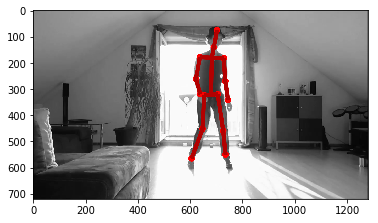

In [160]:
image = make_frame(t)
plt.imshow(image)

In [185]:
animation = mpe.VideoClip(make_frame, duration=times[-1])
audio = original.audio.set_duration(times[-1])
animation = animation.set_audio(audio)

# clip = mpe.clips_array([[original, animation]])
animation.write_videofile('test.mp4', fps=fps, audio_codec='aac', remove_temp=True)
#animation.ipython_display(fps=26, loop=True, autoplay=True)

[MoviePy] >>>> Building video test.mp4
[MoviePy] Writing audio in testTEMP_MPY_wvf_snd.mp4


100%|██████████| 440/440 [00:00<00:00, 904.00it/s]

[MoviePy] Done.
[MoviePy] Writing video test.mp4



100%|██████████| 579/579 [00:51<00:00, 11.34it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test.mp4 

